In [ ]:

# Modelos: Linear Regression (Baseline) & LARS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Modelado y Preprocesamiento
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression, Lars
from sklearn.metrics import mean_squared_error, r2_score


In [2]:
df = pd.read_csv("/home/alfonso/Documentos/Diplomado_Ciencia_De_Datos/modulo_2/practica 2/opinionesSentimientos.csv")

In [ ]:

# 2. INGENIERÍA DE CARACTERÍSTICAS
df['full_text'] = df['title'].fillna('') + " " + df['text_clean'].fillna('')
df['year'] = df['year'].astype(str)
df['month'] = df['month'].astype(str)

X = df[['full_text', 'country', 'version', 'month', 'year']]
y = df['score'] 
# Nuestra variable a predecir (1 a 5)


In [ ]:

# 3. DIVISIÓN DE DATOS (Fijamos random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:

# 4. PREPROCESADOR
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=1000, ngram_range=(1, 2)), 'full_text'),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['country', 'version', 'month', 'year'])
    ]
)

# Función para que LARS no falle con matrices dispersas
def to_dense(x):
    return x.toarray() if hasattr(x, "toarray") else x


In [ ]:
# 5. CONFIGURACIÓN DE LOS DOS MODELOS

# Pipeline para Regresión Lineal
pipe_lin = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', MaxAbsScaler()),
    ('regressor', LinearRegression())
])

# Pipeline para LARS (Incluye el paso de 'to_dense')
pipe_lars = Pipeline([
    ('preprocessor', preprocessor),
    ('to_dense', FunctionTransformer(to_dense, accept_sparse=True)),
    ('scaler', MaxAbsScaler()),
    ('regressor', Lars(random_state=42))
])

# Hiperparametrización
configs = [
    {
        'nombre': 'Regresion_Lineal',
        'pipeline': pipe_lin,
        'params': {'regressor__fit_intercept': [True, False]}
    },
    {
        'nombre': 'Regresion_LARS',
        'pipeline': pipe_lars,
        'params': {
            'regressor__n_nonzero_coefs': [50, 100, 200],
            'regressor__fit_intercept': [True, False]
        }
    }
]


In [ ]:

# 6. ENTRENAMIENTO, GRIDSEARCH Y EVALUACIÓN

resultados_finales = []

for model_info in configs:
    nombre = model_info['nombre']
    print(f"\n>>> Entrenando {nombre}...")
    
    # GridSearch: Busca la mejor configuración
    grid = GridSearchCV(model_info['pipeline'], model_info['params'], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    mejor_modelo = grid.best_estimator_
    
    # Métricas de Train y Test
    y_train_pred = mejor_modelo.predict(X_train)
    y_test_pred = mejor_modelo.predict(X_test)
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    r2_test = r2_score(y_test, y_test_pred)
    
    print(f"Mejor configuración: {grid.best_params_}")
    print(f"Error en Train (RMSE): {rmse_train:.4f}")
    print(f"Error en Test (RMSE): {rmse_test:.4f}")
    print(f"R2 Score (Calidad): {r2_test:.4f}")
    
    # Generar CSV con resultados
    res_df = pd.DataFrame(grid.cv_results_)
    res_df['modelo_nombre'] = nombre
    resultados_finales.append(res_df)
    
    # Generar archivo pickle del mejor modelo
    with open(f"modelo_{nombre.lower()}.pkl", 'wb') as f:
        pickle.dump(mejor_modelo, f)



>>> Entrenando Regresion_Lineal...
Mejor configuración: {'regressor__fit_intercept': True}
Error en Train (RMSE): 0.0001
Error en Test (RMSE): 1.4400
R2 Score (Calidad): 0.3053

>>> Entrenando Regresion_LARS...


/home/alfonso/Documentos/Diplomado_Ciencia_De_Datos/venv/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 79 iterations, i.e. alpha=1.158e-02, with an active set of 79 regressors, and the smallest cholesky pivot element being 9.884e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/alfonso/Documentos/Diplomado_Ciencia_De_Datos/venv/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 98 iterations, i.e. alpha=9.306e-03, with an active set of 93 regressors, and the smallest cholesky pivot element being 8.689e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(
/home/alfonso/Documentos/Diplomado_Ciencia_De_Datos/venv/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropp

Mejor configuración: {'regressor__fit_intercept': True, 'regressor__n_nonzero_coefs': 100}
Error en Train (RMSE): 1.0874
Error en Test (RMSE): 1.3012
R2 Score (Calidad): 0.4328


/home/alfonso/Documentos/Diplomado_Ciencia_De_Datos/venv/lib/python3.12/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 94 iterations, i.e. alpha=9.084e-03, with an active set of 93 regressors, and the smallest cholesky pivot element being 9.424e-08. Reduce max_iter or increase eps parameters.
  warnings.warn(


In [8]:

# 7. EXPORTAR TABLA DE RESULTADOS (CSV)
tabla_reporte = pd.concat(resultados_finales, ignore_index=True)
tabla_reporte.to_csv("resultados_gridsearch_regresion.csv", index=False)
print("\n✅ Proceso completado. Archivos .pkl y .csv generados.")



✅ Proceso completado. Archivos .pkl y .csv generados.


/tmp/ipykernel_20271/1967247682.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_10, x='Impacto', y='Variable', palette='coolwarm')


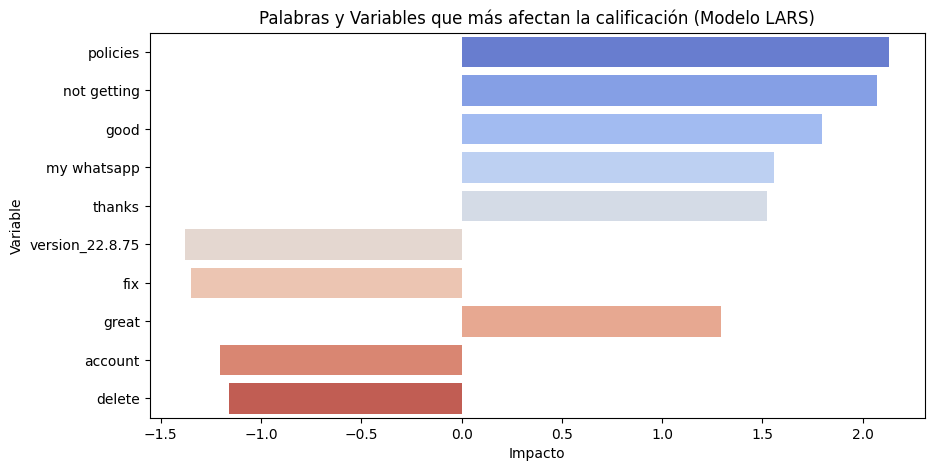

In [9]:

# 8. VISUALIZACIÓN DE IMPORTANCIA
mejor_lars = grid.best_estimator_ if nombre == 'Regresion_LARS' else mejor_modelo
vect = mejor_lars.named_steps['preprocessor'].named_transformers_['text']
all_features = np.concatenate([vect.get_feature_names_out(), 
                               mejor_lars.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out()])
coefs = mejor_lars.named_steps['regressor'].coef_

df_imp = pd.DataFrame({'Variable': all_features, 'Impacto': coefs})
df_imp['Abs'] = df_imp['Impacto'].abs()
top_10 = df_imp.sort_values('Abs', ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(data=top_10, x='Impacto', y='Variable', palette='coolwarm')
plt.title("Palabras y Variables que más afectan la calificación (Modelo LARS)")
plt.show()